In [93]:
import numpy as np

from utils import *
from core import *
import imageio.v3 as iio
from PIL import Image

im = iio.imread('../assets/800px-SheppLogan.png')

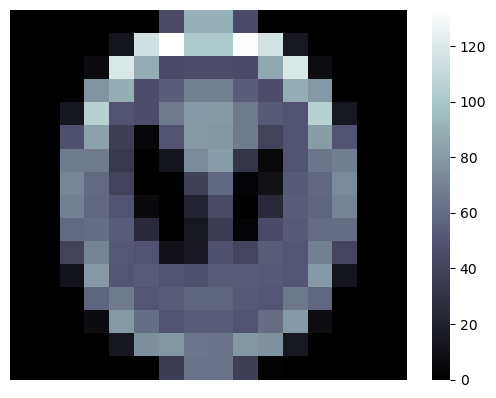

In [94]:
# loading image
new_res = 16

img = Image.fromarray(im).resize((new_res, new_res))
img = np.array(img.convert('L'))
plot_image(img, cmap='bone')

In [95]:
recon = Reconstruction(
  num_iterations=200,
  no_of_detectors=new_res,
  source_to_object=18,
  source_to_detector=51,
  size_of_object=20,
  no_of_rotations=new_res,
  angle_bw_detectors=0.12,
  resolution=new_res
)

Performing decomposition:  75%|███████▌  | 192/256 [00:00<00:00, 213.80it/s]

Matrix has shape = (256, 256)
Matrix has Rank = 192


## Forward Problem

solving the forward problem of obtaining detector readings using image matrix (shepp Logan)

In [96]:
b = recon.A @ img.flatten()
b.shape

(256,)

## Backward Problem

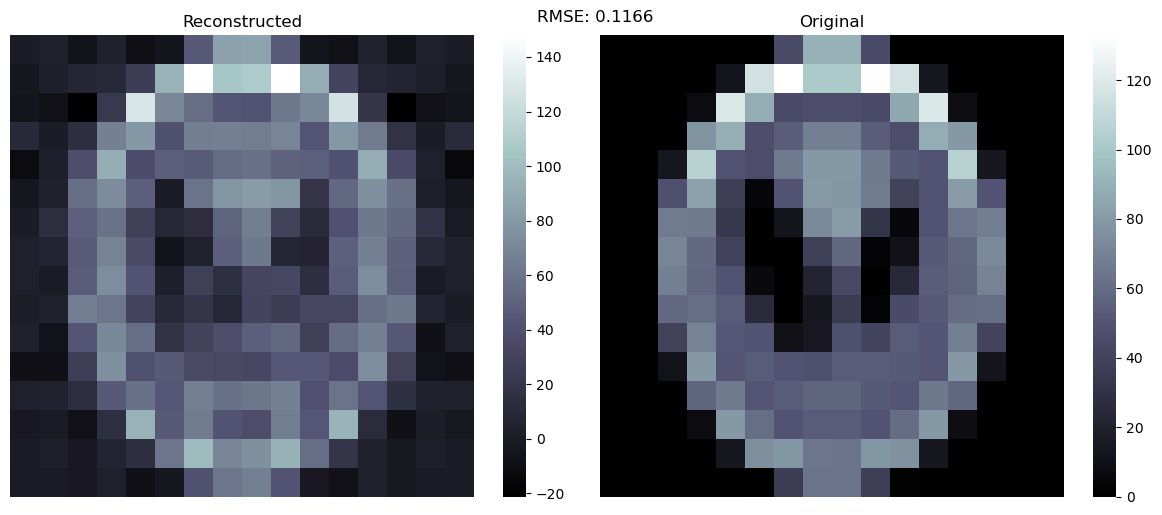

In [97]:
plot_images(recon.solve(b), img, cmap='bone')